## Model Training 

**Author: J. Hickman**
* This notebook vectorizes the corpus

* Partitions data into training and test 
* Then trains the following models
  * Multi-nomial Naive Bayes classifier 
  * KNN classifier
    * (with a hyper-parameter tuning demonstrating)
  * KNN regression  
    * (with a hyper-parameter tuning demonstrating)

### About the data: 

* X strings from wikipedia articles about different topics (need to be vectorized first)
  
* y1 = CATEGORICAL topics  (0,1,2) (pizza, metallurgy, basketball)  --> Classification targets 
* y2 = NUMERIC CONTINUOUS (sentiment score -1 to 1)  --> Regression targets

### Overview

* **Classification**
  * **Multinomial Naive Bayes (MultinomialNB).** 
    * The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). 
    * The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.
    * https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
  * **Gaussian Naive Bayes (GaussianNB).** 
    * Gaussian Naive Bayes supports continuous valued features and models each as conforming to a Gaussian (normal) distribution. 
    * An approach to create a simple model is to assume that the data is described by a Gaussian distribution with no co-variance (independent dimensions) between dimensions.
    * https://iq.opengenus.org/gaussian-naive-bayes/
  * **KNN** 
    * Classifier implementing the k-nearest neighbors vote.
* **Regression**
  * **KNN**
    * Regression based on k-nearest neighbors.
    * The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.


### Import

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics import accuracy_score


### Read and re-format

In [70]:
#RELOAD FILE AND PRETEND THAT IS OUR STARTING POINT 
df=pd.read_csv('wiki-crawl-results.csv')  
print(df.shape)

#CONVERT FROM STRING LABELS TO INTEGERS 
labels=[]; #y1=[]; y2=[]
y1=[]
for label in df["label"]:
    if label not in labels:
        labels.append(label)
        print("index =",len(labels)-1,": label =",label)
    for i in range(0,len(labels)):
        if(label==labels[i]):
            y1.append(i)
y1=np.array(y1)

# CONVERT DF TO LIST OF STRINGS 
corpus=df["text"].to_list()
y2=df["sentiment"].to_numpy()

print("number of text chunks = ",len(corpus))
print(corpus[0:3])


(970, 3)
index = 0 : label = school district
index = 1 : label = school takeover
index = 2 : label = education reform
number of text chunks =  970
['12 public school function unit local usually operate several school largest urban suburban district operate hundred school practice varies significantly state case within state american operate independent local governmental unit grant authority within geographic limit created state law executive legislative power locally controlled policy operation independent case held board education depending state law member local board education often referred informally school board may elected appointed political office holder serve ex officio combination independent legally separate body corporate political', 'controlling law varies united state operate independent local governmental unit exclusive authority 12 public educational operation policy extent control set state level law litigation common law firm specialize school law handle litigation 

### Vectorize the text data

In [71]:

# INITIALIZE COUNT VECTORIZER
# minDF = 0.01 means "ignore terms that appear in less than 1% of the documents". 
# minDF = 5 means "ignore terms that appear in less than 5 documents".
vectorizer=CountVectorizer(min_df=0.001)   

# RUN COUNT VECTORIZER ON OUR COURPUS 
Xs  =  vectorizer.fit_transform(corpus)   
X=np.array(Xs.todense())

#CONVERT TO ONE-HOT VECTORS
maxs=np.max(X,axis=0)
X=np.ceil(X/maxs)

# DOUBLE CHECK 
print(X.shape,y1.shape,y2.shape)
print("DATA POINT-0:",X[0,0:10],"y1 =",y1[0],"  y2 =",y2[0])

(970, 10943) (970,) (970,)
DATA POINT-0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] y1 = 0   y2 = 0.6369


### Partition Data

**Assignment 3.2.4: Break data into an 80-20 training/test set** 

As a sanity check, reprint the shapes to make sure everything is correct

```
x_train.shape		: (120, 4)
y_train.shape		: (120,)
X_test.shape		: (30, 4)
y_test.shape		: (30,)
```

In [72]:
# BEFORE SPLIT
print(y1[900:1000])

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [73]:
# INSERT CODE TO PARTITION DATASET INTO TRAINING-TEST

from sklearn.model_selection import train_test_split
test_ratio=0.2

# SPLIT ARRAYS OR MATRICES INTO RANDOM TRAIN AND TEST SUBSETS.
x_train, x_test, y_train, y_test = train_test_split(X, y1, test_size=test_ratio, random_state=0)
y_train=y_train.flatten()
y_test=y_test.flatten()

print("x_train.shape		:",x_train.shape)
print("y_train.shape		:",y_train.shape)

print("X_test.shape		:",x_test.shape)
print("y_test.shape		:",y_test.shape)

x_train.shape		: (776, 10943)
y_train.shape		: (776,)
X_test.shape		: (194, 10943)
y_test.shape		: (194,)


In [74]:
#CHECK TO MAKE SURE IT WAS RANDOMIZED 
print(y_train[0:100])

[0 1 2 0 0 2 0 0 2 2 0 1 2 2 1 0 1 2 0 2 0 2 0 2 1 1 1 1 2 0 2 1 1 2 2 1 1
 0 1 2 2 1 2 1 1 1 2 1 1 0 0 2 1 2 2 1 1 1 1 1 0 0 2 0 2 1 1 2 2 0 1 0 1 0
 2 2 0 2 1 1 0 0 0 2 2 2 1 2 2 2 2 2 2 0 2 1 1 1 0 0]


### Utility function

* Write a function to report accuracy
* Note this will act on object stored in pythons global scope. Therefore as long as everything is named the same you can recycle it for multiple models

In [80]:

def report(y,ypred):
      #ACCURACY COMPUTE 
      print("Accuracy:",accuracy_score(y, ypred)*100)
      print("Number of mislabeled points out of a total %d points = %d"
            % (y.shape[0], (y != ypred).sum()))

def print_model_summary():
      # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
      yp_train = model.predict(x_train)
      yp_test = model.predict(x_test)

      print("ACCURACY CALCULATION\n")

      print("TRAINING SET:")
      report(y_train,yp_train)

      print("\nTEST SET (UNTRAINED DATA):")
      report(y_test,yp_test)

      print("\nCHECK FIRST 20 PREDICTIONS")
      print("TRAINING SET:")
      print(y_train[0:20])
      print(yp_train[0:20])
      print("ERRORS:",yp_train[0:20]-y_train[0:20])

      print("\nTEST SET (UNTRAINED DATA):")
      print(y_test[0:20])
      print(yp_test[0:20])
      print("ERRORS:",yp_test[0:20]-y_test[0:20])

## Classification model-1: Multinomial Naive Bayes  

The following code applies the multi-nomial Naive Bayes classifier to the text data-set generated with wikipeda

### Train model 

* Use SkLearn to train a MultinomialNB model 
*  When the model is trained, insert code to output the following information about the training and test set (your numbers will vary)
   * **Remember that the test set was NOT seen during the training process, and therefore "test" predictions show how the model does on new "unseen" data**
  


In [81]:
from sklearn.naive_bayes import MultinomialNB

# INITIALIZE MODEL 
model = MultinomialNB()

# TRAIN MODEL 
model.fit(x_train,y_train)

# PRINT REPORT USING UTILITY FUNCTION ABOVE
print_model_summary()

ACCURACY CALCULATION

TRAINING SET:
Accuracy: 98.06701030927834
Number of mislabeled points out of a total 776 points = 15

TEST SET (UNTRAINED DATA):
Accuracy: 90.20618556701031
Number of mislabeled points out of a total 194 points = 19

CHECK FIRST 20 PREDICTIONS
TRAINING SET:
[0 1 2 0 0 2 0 0 2 2 0 1 2 2 1 0 1 2 0 2]
[0 1 2 0 0 2 0 0 2 2 0 1 2 2 1 0 1 2 0 2]
ERRORS: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

TEST SET (UNTRAINED DATA):
[2 1 0 2 1 2 2 2 1 1 0 2 1 2 2 2 2 1 2 2]
[2 0 0 2 1 2 2 2 1 1 0 2 1 2 2 2 2 1 2 2]
ERRORS: [ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


## Classification model-2: KNN 

#### Hyper-Parameter tuning

In [77]:
from sklearn.neighbors import KNeighborsClassifier


# HYPER PARAMETER SEARCH FOR OPTIMAL NUMBER OF NEIGHBORS 
num_neighbors=[]
train_accuracy=[]
test_accuracy=[]

# LOOP OVER HYPER-PARAM
for i in range(1,40):
    try:
        # INITIALIZE MODEL 
        model = KNeighborsClassifier(n_neighbors=i)

        # TRAIN MODEL 
        model.fit(x_train,y_train)

        # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
        yp_train = model.predict(x_train)
        yp_test = model.predict(x_test)

        print("n_neighbors =",i)
        acc1=accuracy_score(y_train, yp_train)*100
        acc2=accuracy_score(y_test, yp_test)*100

        num_neighbors.append(i)
        train_accuracy.append(acc1)
        test_accuracy.append(acc2)

        print(" train accuracy:",acc1)
        print(" test accuracy:" ,acc2)
    except:
        print("ERROR: n_neighbors =",i)

ERROR: n_neighbors = 1
ERROR: n_neighbors = 2
ERROR: n_neighbors = 3
ERROR: n_neighbors = 4
ERROR: n_neighbors = 5
ERROR: n_neighbors = 6
ERROR: n_neighbors = 7
ERROR: n_neighbors = 8
ERROR: n_neighbors = 9
ERROR: n_neighbors = 10
ERROR: n_neighbors = 11
ERROR: n_neighbors = 12
ERROR: n_neighbors = 13
ERROR: n_neighbors = 14
ERROR: n_neighbors = 15
ERROR: n_neighbors = 16
ERROR: n_neighbors = 17
ERROR: n_neighbors = 18
ERROR: n_neighbors = 19
ERROR: n_neighbors = 20
ERROR: n_neighbors = 21
ERROR: n_neighbors = 22
ERROR: n_neighbors = 23
ERROR: n_neighbors = 24
ERROR: n_neighbors = 25
ERROR: n_neighbors = 26
ERROR: n_neighbors = 27
ERROR: n_neighbors = 28
ERROR: n_neighbors = 29
ERROR: n_neighbors = 30
ERROR: n_neighbors = 31
ERROR: n_neighbors = 32
ERROR: n_neighbors = 33
ERROR: n_neighbors = 34
ERROR: n_neighbors = 35
ERROR: n_neighbors = 36
ERROR: n_neighbors = 37
ERROR: n_neighbors = 38
ERROR: n_neighbors = 39


### Convergence plot

Text(0, 0.5, 'Training (black) and test (blue) accuracy')

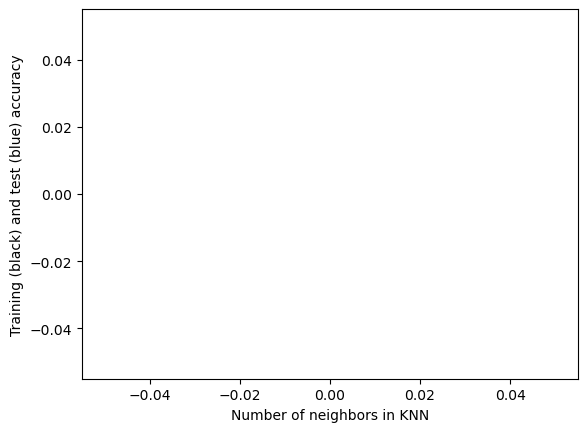

In [78]:
plt.plot(num_neighbors,train_accuracy ,linewidth=2, color='k')
plt.plot(num_neighbors,test_accuracy ,linewidth=2, color='b')

plt.xlabel("Number of neighbors in KNN")
plt.ylabel("Training (black) and test (blue) accuracy")

#### Re-train with optimal parameters

In [79]:
# RETRAIN WITH OPTIMAL HYPER-PARAMETERS

# INITIALIZE MODEL 
model = KNeighborsClassifier(n_neighbors=30)

# TRAIN MODEL 
model.fit(x_train,y_train)

# PRINT REPORT USING UTILITY FUNCTION ABOVE
print_model_summary()

AttributeError: 'NoneType' object has no attribute 'split'

## Regression model-1: KNN 

* fit y2 (sentiment score from -1 to 1) instead of y1 (classes) 

### Re-partition data

In [ ]:

from sklearn.model_selection import train_test_split
test_ratio=0.2
x_train, x_test, y_train, y_test = train_test_split(X, y2, test_size=test_ratio, random_state=0)
y_train=y_train.flatten()
y_test=y_test.flatten()

print("x_train.shape		:",x_train.shape)
print("y_train.shape		:",y_train.shape)

print("X_test.shape		:",x_test.shape)
print("y_test.shape		:",y_test.shape)

x_train.shape		: (776, 10943)
y_train.shape		: (776,)
X_test.shape		: (194, 10943)
y_test.shape		: (194,)


#### Hyper-Parameter tuning

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

# HYPER PARAMETER SEARCH FOR OPTIMAL NUMBER OF NEIGHBORS 
num_neighbors_2=[]
train_error=[]
test_error=[]

# LOOP OVER HYPER-PARAM
for i in range(1,33):
    # INITIALIZE MODEL 
    model = KNeighborsRegressor(n_neighbors=i)

    # TRAIN MODEL 
    model.fit(x_train,y_train)

    # OUTPUT PREDICTIONS FOR TRAINING AND TEST SET 
    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)

    print("n_neighbors =",i)
    # shift=1+np.min(y_train) #add shift to remove division by zero 
    err1=mean_absolute_error(y_train, yp_train) 
    err2=mean_absolute_error(y_test, yp_test) 

    num_neighbors_2.append(i)
    train_error.append(err1)
    test_error.append(err2)

    print(" train MAE:",err1)
    print(" test MAE:" ,err2)

AttributeError: 'NoneType' object has no attribute 'split'

### Convergence plot

Text(0, 0.5, 'Training (black) and test (blue) MAE (error)')

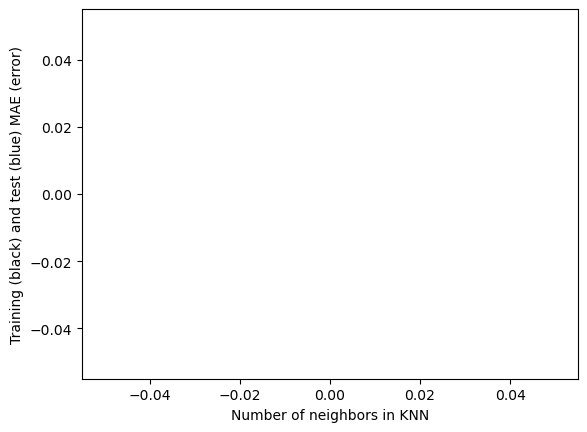

In [ ]:
plt.plot(num_neighbors_2,train_error ,linewidth=2, color='k')
plt.plot(num_neighbors_2,test_error ,linewidth=2, color='b')

plt.xlabel("Number of neighbors in KNN")
plt.ylabel("Training (black) and test (blue) MAE (error)")

#### Re-train with optimal parameters

In [ ]:
# INITIALIZE MODEL 
model = KNeighborsRegressor(n_neighbors=35)

# TRAIN MODEL 
model.fit(x_train,y_train)

# OUTPUT PREDICTIONS FOR TRAINING AND TEST SET 
yp_train = model.predict(x_train)
yp_test = model.predict(x_test)

AttributeError: 'NoneType' object has no attribute 'split'

### Parity Plot

* Plotting y_pred vs y_data lets you see how good the fit is

* The closer to the line y=x the better the fit (ypred=ydata --> prefect fit)

In [ ]:
plt.plot(y_train,yp_train ,"o", color='k')
plt.plot(y_test,yp_test ,"o", color='b')
plt.plot(y_test,y_test ,"-", color='r')

plt.xlabel("y_data")
plt.ylabel("y_pred (blue=test)(black=Train)")

NameError: name 'yp_train' is not defined

In [ ]:
# # RUN CLASSIFICATION REPORT FOR TRAINING SET
# from sklearn.metrics import classification_report
# print("Classification Report \n {}".format(classification_report(y_train, yp_train, labels=range(0,10))))